# A First Computational Fluid Dynamic Simulation

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

There are many parts to a CFD application.
* Know/Decide what mathematical system I want to solve, i.e. I want to define the mathematical equation I'm trying to approximate;
* Domain (a.k.a. grid): the area of space that we're solving the equations over (plus any boundary space, represented by ghost cells).

There's more, but let's start by examining those two.

We'll build a first application that calculates a wave propagating in a one dimensional domain. The basic system we will solve is what's called the 1-way (linear) wave equation, which has the basic features of flow/information propagation:

$\frac{\partial P}{\partial t} + c \frac{\partial P}{\partial x} = 0$

## Domain: the location of points that will be computed

We will define a grid of 5 evenly spaced points between $x_L=0$ and $x_R=5$ as an example.

In [3]:
xL   = 0
xR   = 5
npts = 5
nghost = 2

We have to calculate some important properties:
* spacing between 2 points, $dx$: in the variable dx,
* position of each point, $x_i$: in the variable xi = [x_1, x_2, x_3, ... x_5].

In [12]:
dx  = (xR-xL)/npts
#ind = 1-nghost:npts+nghost
xi = np.linspace(xL-dx,xR+dx,npts+2*nghost) #(ind-1)*dx+dx/2
print(dx)
xi

1.0


array([-1.   , -0.125,  0.75 ,  1.625,  2.5  ,  3.375,  4.25 ,  5.125,
        6.   ])

Let's turn this process into a function that takes, as inputs:
* left domain boundary, xL
* right domain boundary, xR
* number of points, npts

and returns
* grid size, dx
* location of points, xi
* vector of indices

(This function is basically the ***mesher*** of a proper CFD package!)

In [4]:
function [dx,ind,xi] = grid(xL,xR,npts,nghost)
  dx  = (xR-xL)/npts;
  ind = 1-nghost:npts+nghost;
  xi  = (ind-1)*dx + dx/2;
end

[dx,ind,xi] = grid(0,5,5,2)

dx = 1
ind =

  -1   0   1   2   3   4   5   6   7

xi =

 Columns 1 through 8:

  -1.5000  -0.5000   0.5000   1.5000   2.5000   3.5000   4.5000   5.5000

 Column 9:

   6.5000



What are some of the other parts of a CFD application? Here's two more:
* Initial Condition
* Boundary Condition(s)

## Initial Conditions

Let's use a sine wave as our first try. 'P(x,t=0) = sin(x)'

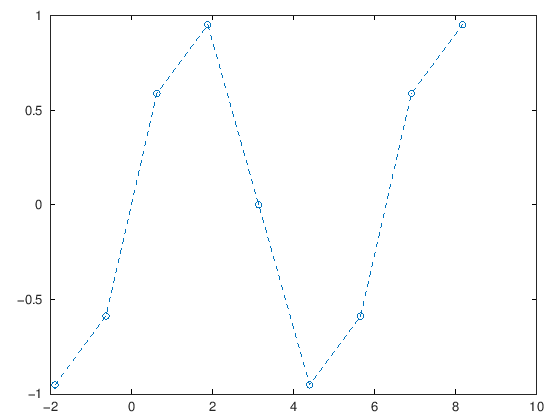

In [5]:
xL = 0; xR = 2*pi; npts = 5; nghost = 2;
[dx,ind,xi] = grid(xL,xR,npts,nghost);  %Generate the discretization a.k.a. the grid
P0 = sin(xi);                  %Calculate the initial condition
plot(xi,P0,'o--')              %Plot the initial condition as a check

## Boundary Conditions

What happens at the boundary. We will use a periodic boundary for simplicity.

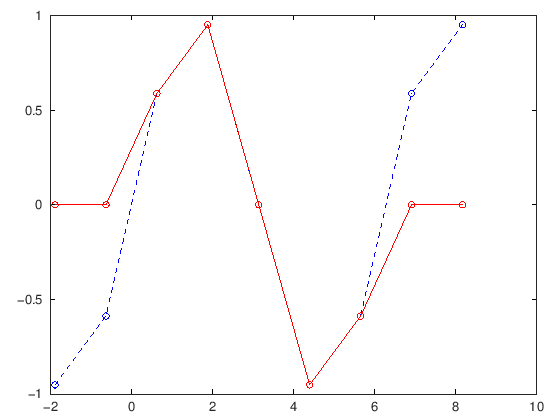

In [6]:
function [Pout] = update_boundary_condition(Pin,nghost,condition, value)
  Pout = Pin;
  switch (condition)
    case "periodic"
      for i = 1:nghost
        disp('periodic chosen')
      end
    case "constant"
      for i = 1:nghost
        Pout(i) = value;
        Pout(end-(i-1)) = value;
      end
    end
end

P1 = update_boundary_condition(P0,nghost,'constant',0);
plot(xi,P0,'o--b',xi,P1,'o-r')

## Time-update: marching forwards in time

To march by one time-step, you need to integrate the linear-advection differential equation:
$\frac{\partial P}{\partial t} + c \frac{\partial P}{\partial x} = 0$.

To do this, we will use what we call a ***first order (in time), first order (in space), explicit, finite-difference scheme***.

We will approximate the derivatives by numerical (finite) differences. In Russia, we term this the method of lines, which is a nice way to describe the method. Picture the domain you are solving over as a line of points. The spatial distribution is horizontal. Each line is a different time step. The current time is t and is known. The previous time step is j-1, at time t-dt such that the time step is dt. The j-1 time is also known. The next time step, which is unknown and the one we are looking for is j+1 at time t + dt. In deriving our approximations, we will just the (i,j+1) point as the target point we are looking for as a function of the j points. (We could also have multi-level schemes that depend on j, j-1, etc.)

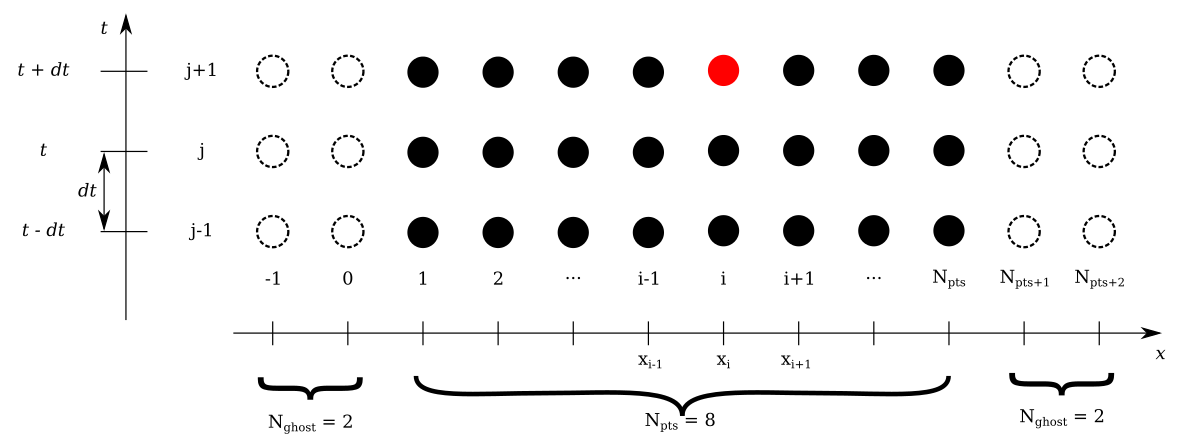

The spatial derivative between two points *i* and *i+1* can be expressed by assuming we have a straight line between the two points. This is a $1^\mathrm{st}$ order approximation to a $1^\mathrm{st}$ order derivative:

$\frac{\partial P}{\partial x} = \frac{\Delta P}{\Delta x} = \frac{P_{i} - P_{i-1}}{x_{i}-x_{i-1}}$.

*Note that the above formula is called a 1st order **backwards** difference formula because it uses the points i and i-1. We could have used a **forward** difference formula by using the points i and i+1. We'll revisit this later.*

The same can be done for time. Our domain now evolves in time and we indicate the time step with the subscript *j*. The current time-step is *j*, the next time step (the one we want to calculate) is *j+1*. The previous time step is *j-1*. The previous spatial derivative, if we calculate at the current time-step, is

$\frac{\partial P}{\partial x} = \frac{\Delta P}{\Delta x} = \frac{P_{i,j} - P_{i-1,j}}{x_{i}-x_{i-1}}$.

We will calculate the time derivative for the point *i*, between the times *j* and *j+1*. The value $t_j$ is the current time, while the value $t_{j+1} = t_j + dt$ is the next time step, where $dt$ is the timestep.

$\frac{\partial P}{\partial t} = \frac{\Delta P}{\Delta t} = \frac{P_{i,j+i} - P_{i,j}}{t_{j+1}-t_j}$.

We re-assemble the two different approximations to our original differential equation to obtain a finite difference formula:

$\frac{\partial P}{\partial t} = \frac{\Delta P}{\Delta t} = \frac{P_{i,j+i} - P_{i,j}}{t_{j+1}-t_j} = -c \frac{\partial P}{\partial x} = -c \frac{\Delta P}{\Delta x} = -c \frac{P_{i,j} - P_{i-1,j}}{x_{i}-x_{i-1}}$

or simply

$\frac{P_{i,j+i} - P_{i,j}}{t_{j+1}-t_j} = -c \frac{P_{i,j} - P_{i-1,j}}{x_{i}-x_{i-1}}$.

We can solve for the value of *P* at point *i* and at the next time-step *j+1* and we have:

$P_{i,j+i} = P_{i,j} -c \left(t_{j+1}-t_j\right) \frac{P_{i,j} - P_{i-1,j}}{x_{i}-x_{i-1}}$.

For a uniform grid spacing and a constant time-step, we write the finite difference formula with the following formulae:

$\Delta t = t_{j+1}-t_j$

$\Delta x = x_{i}-x_{i-1}$

to have:

$ P_{i,j+i} = P_{i,j} -\frac{c \Delta t}{\Delta x} ( P_{i,j} - P_{i-1,j} ) $.

Two notes:
* The above formula to solve for P at the next time step is called an *explicit* formula because $P_{i,j+1}$ only depends on quantities at time index j and not at time index j+1 itself. 
* The quantity $\mathrm{CFL} = \frac{c \Delta t}{\Delta x}$ is very important for our code to work properly. It is called the Courant-Friedrich-Levy criterion.The CFL has to be small enough for our code to work. How small? That depends on the particular approximations we are making. For explicit formulae, it must always be CFL ${} \leq 1$, but usually the CFL number must be smaller than one.

But nevermind for now. Let's implement one time-step:

You only need to calculate the interior points and not the ghost points, so we will only run through the points nghost + 1 to npts+ nghost.

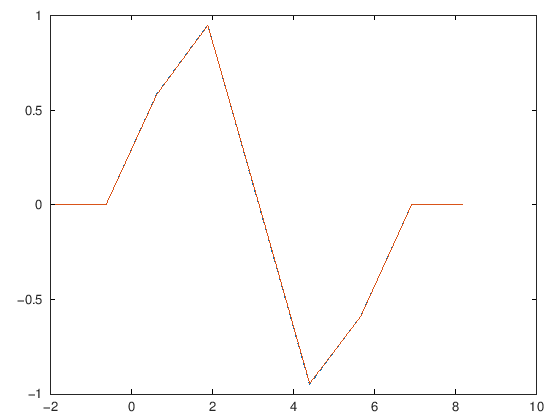

In [7]:
P2 = P1;   %Initialize a vector for the 2nd time-step to have the same dimensions as the one for the current time-step
c = 1;     %Define a sound speed. We didn't define that at the beginning of the exercise
dt = 0.01; %Pick a small time-step
t  = 0.00; %Initialize the value of time. This is the time at P1.

for i = nghost+1 : 1 : npts+nghost
  P2(i) = P1(i) - (c * dt/dx)*(P1(i)-P1(i-1));
  t = t + dt;
end

plot(xi,P1,'--',xi,P2,'-') 

The two curves look very similar because we only went forward by one time step, $\Delta t = 0.01$ Since the sound speed is $c = 1$ and $\Delta t = 0.01$, it takes a lot of time steps for the wave to move along an appreciable distance. We can calculate the number of time steps, $n_{steps}$, required for the wave to move forward a distance $L$.

$n_{steps} = L / ( c \Delta t)$

Let's compute that for $L=1$, $c=1$, and $dt=0.01$ as we have now.

In [9]:
nsteps = 1/(c*dt)

nsteps = 100


If we repeat the individual time step process from above, but after each time step we overwrite the current time step P1 with the new time step P2, we can integrate from an initial to a final time. We also need to re-apply the boundary conditions every time step. We'll see the wave move a certain distance. 

**We've now reached the point where we are ready to put all the parts together!!**

# Exercise Section
The numerical answers are given after each exercise so you can see whether you are going in the right direction.

## Exercise 1: Implement the periodic boundary condition in the update_boundary_condition() function

This is kind of self-explanatory. In the function above, add two lines of code to implement the periodic boundary condition.

## Exercise 2: Putting our first application together!

The sequence of steps we need to take is as follows:
1. Define the problem parameters xL=0, xR=5, npts=10, nghost=1 (you only need 1 ghost cell for now). *this step is done for you*
2. Use the grid() function to calculate the grid spacing dx, the vector of indices, ind, and the grid point locations, xi.
3. Compute the initial conditions and store it in a vector P0 = $sin(2\pi x_i/5)$. I suggest you do this so you can keep the vector P0 untouched and plot it at the end.
4. Apply the boundary condition to P0 by using the update_boundary_condition() function. Use the periodic boundary condition you updated in the previous exercise 1.
5. Initialize the current time-step in vector P1 and calculate the initial time t = 0. *this step is done for you*
6. Initialize a vector P2 so it has the same shape as P1. *this step is done for you*
7. Specify the wave speed c = 1, the time step dt = 0.001 and the wave travel distance, L = 5. This means the wave will loop back on its own. *this step is done for you*
8. Compute the required number of steps and the CFL number. You won't necessarily use the CFL number, but it's good to see it on the screen to make sure it's much smaller than unity.
9. Update the time-step update loop to go through nsteps time-steps of wave propagation. The overall process in that portion of the code should be
* loop over time steps
* loop through interior points to calculate next time step
* update time value
* overwrite current time step P1 with the newly calculated time-step P2.
* update the boundary conditions of P1
* repeat the time stepping loop
10. Finally, plot the initial condition and the final calculated time step. *this step is done for you*


xL = 0
xR = 5
npts = 10
nghost = 1
t = 0
c = 1
dt = 1.0000e-03
t = 0
L = 5
nsteps = 5000
CFL = 2.0000e-03
Err = 0.8633


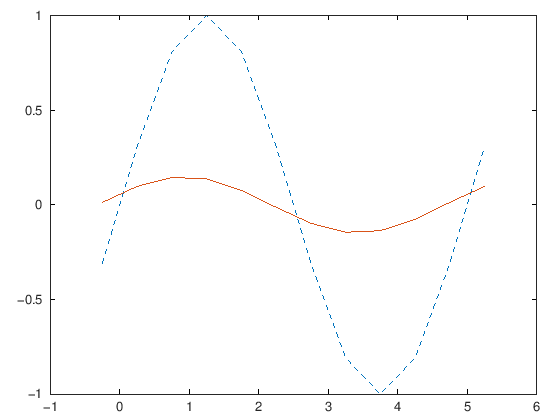

In [11]:
%start by defining the grid of the system
xL   = 0
xR   = 5
npts = 10
nghost = 1

%... use the grid() function ...

%P0 = ...; %Calculate initial condition in a vector that will stick around later for plotting.
%P0 = ...; %Apply boundary condition to initial condition

P1 = P0;   %Initialize the first time step
t = 0.00
P2 = 0*P1;   %Initialize a vector for the 2nd time-step to have the same dimensions as the one for the current time-step

c = 1      %Define a sound speed. We didn't define that at the beginning of the exercise
dt = 0.001  %Pick a small time-step
t  = 0.00  %Initialize the value of time. This is the time at P1.
L  = 5     %pick the travel distance we want.

%nsteps = ...
%CFL = ...

%complete this section to integrate over several steps..
for i = nghost+1 : 1 : npts+nghost
  P2(i) = P1(i) - (c * dt/dx)*(P1(i)-P1(i-1));
end
t = t + dt;


%Don't touch this next line until exercise 5
%Err = ...

plot(xi,P0,'--',xi,P1,'-') 

## Exercise 3: Implement forward difference formula

Recopy your code in the cell below and, instead of the backward difference formula for the space derivative, 

$ P_{i,j+i} = P_{i,j} -\frac{c \Delta t}{\Delta x} ( P_{i,j} - P_{i-1,j} ) $,

use the forward difference formula, 

$ P_{i,j+i} = P_{i,j} -\frac{c \Delta t}{\Delta x} ( P_{i+1,j} - P_{i,j} ) $.

**You only need to change characters in a single line in the code.**

xL = 0
xR = 5
npts = 10
nghost = 1
t = 0
c = 1
dt = 1.0000e-03
t = 0
L = 5
nsteps = 5000
CFL = 2.0000e-03
Err = 5.2180


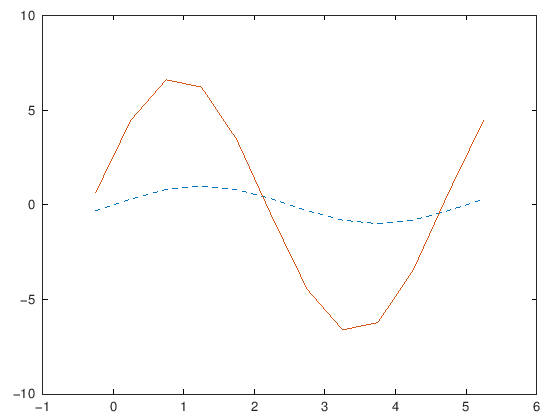

In [12]:
...copy your code from exercise 2 here and modify accordingly...

Describe the differences between the two outputs.

**Observed differences:**

...write your answer here...

## Exercise 4: Let's go 2nd order!!!

Instead of the first order backward-difference approximation in space,

$\frac{\partial P}{\partial x} = \frac{P_{i,j} - P_{i-1,j}}{dx}$,

or the first order forward-difference approximation in space,

$\frac{\partial P}{\partial x} = \frac{P_{i+1,j} - P_{i,j}}{dx}$,

we can use the **2nd order** centered-difference approximation for the spatial derivative! That formula looks like this:

$\frac{\partial P}{\partial x} = \frac{1}{2}\frac{P_{i+1,j} - P_{i-1,j}}{dx}$.

Recopy your code from exercise 2 or 3 in the next cell and change the difference formula to the 2nd order centered difference. **You will again only need to change a single line of code and all the parameters can remain the same, including nghost.** 

*(To be completely honest, it's because you had too many ghost cells before. For the 1st order difference formulas, you only needed 1 ghost cell total. Either 1 on the left or one on the right, depending on whether you were using the backward or forward difference formula. For the centered difference, you need 2 ghost cells total, 1 on the left AND 1 on the right. The grid() function from earlier already creates a symmetric number of ghost cells on both sides, so that's not a problem for you here.)*

xL = 0
xR = 5
npts = 10
nghost = 1
t = 0
c = 1
dt = 1.0000e-03
t = 0
L = 5
nsteps = 5000
CFL = 2.0000e-03
Err = 0.077849


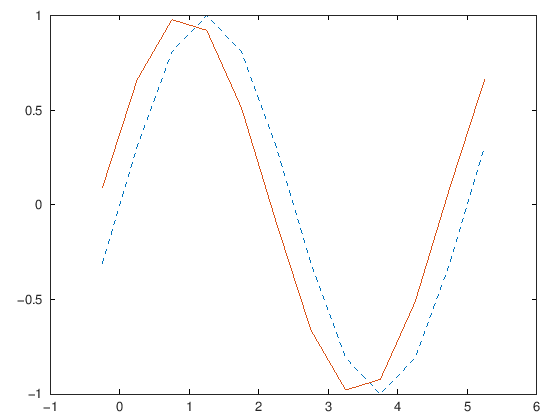

In [21]:
...copy your code from exercise 2 or 3 here and modify accordingly...

## Exercise 5: Go back and compute the error!

Go back to the codes of exercices 2,3, and 4. At the very end, you can compute the error the simulation makes. There are many ways to compute the error and here, you will use something called the L1-norm. The name sounds daunting, but it's basically kind of what you expect. The amount of error at one point (i) on the grid is Error = $P_1(i) - P_0(i)$. We call this the absolute error because it has units of $P$, i.e. $E_\mathrm{abs} = P_1(i) - P_0(i)$. *(This is in contrast to the relative error, i.e. the error relative to the value itself. In this case, $E_\mathrm{rel} = E_\mathrm{abs}/P_0(i) = (P_1(i) - P_0(i))/P_0(i)$)*. The error number can be positive or negative and negative errors are just as bad as positive errors. Therefore, we'll take the absolute value $|E_\mathrm{abs}|$. There's a different value of the relative error for each grid point i, so we'll take the worst one to tell us how bad our solution is.

In other words, for the vector of the simulated solution, $P_1$, and the vector of the exact (and initial solution) $P_0$, you can get a measure of the error in the following way:

Err = max(  abs(  (P1 - P0)   )   ).

Taking the maximum value of error is basically what the L1-norm is.

Go back to the three exercises and add the error computation line to see what the effect is.

**What are your observations about the error? If you change the number of interior points, npts, or the time-step, dt, what happens? How does the error compare between the different methods, for the same parameters?**

...write your observations here...

## (Bonus) Exercise 6: Accelerate your code!

Your codes are going to be very slow. You can accelerate them quite a bit by eliminating one of the costly loops and using vector operations. Recopy your code and accelerate execution time.

In [10]:
... copy your code from exercise 2,3 or 4 here and make changes...

Continuation prompt found - input was incomplete:
... copy your code from exercise 2,3 or 4 here and make changes...


## (Bonus) Exercise 7: Another part of the code that slows everything down?

Aside from the loop you accelerated before, there's another part of your code that's very, very slow. Can you guess what it is? (Don't try to fix it. Depending on the method you attempt, it could be a little advanced.)

**Another way to accelerate the code is ...**

... enter your best guess here...